In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
df = pd.read_csv('/content/twitterds.csv').head(1000)

# **Data Pre Processing and data cleaning**

#**1. Filtering non-engaging tweets:**
Removes tweets with zero replies, retweets, and likes.

#**2. Language filtering:**
Retains only English tweets.

# **3. Column selection:**
Keeps relevant columns ('tweet', 'replies_count', 'retweets_count', 'likes_count', 'time').

# **4. ID assignment:**
Adds an 'id' column with unique identifiers.

# **5. Column reordering:**
Rearranges columns for better readability.

# **6. Index setting:**
Sets the 'id' column as the index for the DataFrame.

In [ ]:
df = df[~((df['replies_count'] == 0) & (df['retweets_count'] == 0) & (df['likes_count'] == 0))]
df = df[df['language'] == 'en']

In [ ]:
df = df[['tweet', 'replies_count', 'retweets_count', 'likes_count', 'time']].copy()
df['id'] = range(1, len(df) + 1)
df = df[['id', 'time', 'tweet', 'replies_count', 'retweets_count', 'likes_count']]
df.set_index('id', inplace=True)
df['total_engagement'] = df['replies_count'] + df['retweets_count'] + df['likes_count']
df.head()

,time,tweet,replies_count,retweets_count,likes_count,total_engagement
id,,,,,,
1,00:35:58,2/ The nation's ties with Russia are appearing...,1,0,0,1
2,00:35:58,1/ https://t.co/hmgF0DVoJO Pro-Russia movemen...,1,0,0,1
3,00:35:37,@IsaVulpes @garhunt05 @caitoz Lmao if all Russ...,0,0,1,1
4,00:35:30,In contrast &amp; similarly to Russia’s war of...,1,0,0,1
5,00:35:18,@RepMTG Since you're so against assisting Ukra...,0,1,1,2


# **Tokenize tweets and process words**

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return words
df['processed_tweet'] = df['tweet'].apply(preprocess_text)
all_keywords = set()
for words_list in df['processed_tweet']:
    all_keywords.update(words_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#**Hugging Face Senitment Scoring**

The below code augments each row in the original DataFrame with sentiment probabilities, specifically for positive, neutral, and negative sentiments. Utilizing a pre-trained sentiment analysis model and tokenizer (CardiffNLP Twitter RoBERTa-based), the code processes each tweet in the DataFrame. For every tweet, sentiment scores are generated, and the resulting probabilities are incorporated into new columns for positive, neutral, and negative sentiments. This enhancement enriches the DataFrame with detailed sentiment information, enabling a more nuanced analysis of the emotional tone associated with each tweet in terms of its positivity, neutrality, and negativity.

In [ ]:
Model_Name = f"cardiffnlp/twitter-roberta-base-sentiment"
auto_tokenizer_ = AutoTokenizer.from_pretrained(Model_Name)
model = AutoModelForSequenceClassification.from_pretrained(Model_Name)

def polarity(example):
    ET = auto_tokenizer_(example, return_tensors='pt')
    result = model(**ET)
    obtained_scores = result[0][0].detach().numpy()
    obtained_scores = softmax(obtained_scores)
    final_result = {
        'negative' : obtained_scores[0],
        'neutral' : obtained_scores[1],
        'positive' : obtained_scores[2]
    }
    return final_result

res = {'negative':[], 'neutral':[], 'positive':[]}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['tweet']
    for key, value in polarity(text).items():
      res[key].append(value)

df_res = pd.DataFrame(res)
df = pd.concat([df, df_res], axis=1)

  0%|          | 0/175 [00:00<?, ?it/s]

Next spep is to append an additional column to each row in the original DataFrame, containing either the specific country mentioned in the tweet or a general statement if no country is identified. This is achieved through a process that likely involves text analysis or entity recognition. The code iterates through each tweet in the DataFrame and determines the relevant country information. If a country is identified, it is added to the new column; otherwise, a general statement is included. This enhancement adds contextual information to the DataFrame, offering insights into the geographical focus of each tweet.

In [ ]:
def classify_tweet(tweet):
    russia_keywords = ["Vladimir Putin", "Kremlin", "Russian Federation", "Moscow", "Russian military","Annexation", "Crimea", "Donetsk", "Luhansk", "Eastern Ukraine","Intervention", "Hybrid warfare", "NATO", "Black Sea", "Military buildup","Sanctions", "Oligarchs", "S-400 missile system", "Cyber warfare", "Strategic interests","Propaganda", "Novichok", "INF Treaty", "RT (Russia Today)", "Wagner Group","Eurasian Economic Union", "CSTO (Collective Security Treaty Organization)","Energy pipelines", "Ukraine-Russia relations", "Minsk agreements", "Donbas region","Gazprom", "Navalny", "OSCE", "Russian propaganda", "War crimes", "Syrian conflict","Kaliningrad", "Annexation of South Ossetia", "Caspian Sea", "Federal Security Service (FSB)","Russian economy", "Baltic states", "Missile technology", "GRU (Main Intelligence Agency)","Arctic expansion", "Russian diaspora", "Baltic Sea", "Border disputes", "Russian nationalism","Moldova", "Abkhazia", "Ongoing conflict", "Russian arms exports", "Black Sea Fleet","Treaty of Friendship", "Russian interference", "Russian veto (UN Security Council)","Russian military exercises", "Eurasian Customs Union", "Baltic states NATO membership","CSTO military alliance", "Russian aggression", "Economic leverage", "Annexation of Abkhazia","Northern Fleet", "Russian foreign policy", "Annexation of Transnistria", "Russian energy dominance","Collective defense", "Donbas insurgency", "Kursk submarine disaster", "Military modernization","INF Treaty withdrawal", "Russian arms industry", "Nuclear capabilities","Russian military bases abroad", "Baltic Sea security", "Russian political system","Wagner mercenaries", "Duma (Russian parliament)", "Russian territorial claims","Treaty of Friendship with Ukraine", "Russian military doctrine", "Arctic militarization","Russian cyber threats", "Russian intervention in Syria", "Russian veto in the UN","Strategic partnership with China", "Russian military technology", "Black Sea security","Russian military intelligence", "Russian military presence in Central Asia","Russian military budget", "Russian military influence in the Middle East", "Arctic Council","Russian space program", "Nord Stream pipeline", "Russian nationalism","Russian military intervention in Georgia"]

    ukraine_keywords = ["Kyiv", "Zelensky", "Ukrainian Armed Forces", "Euromaidan", "Maidan Square","Crimean Peninsula", "Sevastopol", "Donbas", "Donetsk People's Republic (DPR)","Luhansk People's Republic (LPR)", "Annexation referendum", "Annexation of Crimea","War in Donbas", "Ukrainian nationalism", "Azov Battalion", "Anti-corruption efforts","Holodomor", "Chornobyl (Chernobyl)", "NATO membership", "EU Association Agreement","Minsk Protocol", "Minsk II Agreement", "OSCE monitoring", "International support","Humanitarian crisis", "IDPs (Internally Displaced Persons)", "Ukrainian diaspora","Russian-backed separatists", "Territorial integrity", "Economic reforms","Energy independence", "Anti-Russian sentiment", "Ukrainian language","Black Sea security", "Budapest Memorandum", "Security sector reform", "Cybersecurity","Ongoing conflict", "Ceasefire violations", "Crimean Tatars", "Ukrainian economy","IMF loans", "Western sanctions", "Ongoing negotiations", "National Guard of Ukraine","Ukrainian political system", "Volodymyr Groysman", "Petro Poroshenko","Yulia Tymoshenko", "Judicial reform", "Border control", "Odessa", "Kharkiv", "Lviv","Odesa massacre", "War crimes investigations", "Donbas blockade", "Donetsk airport","Debaltseve", "Mariupol", "Luhansk airport", "War fatigue", "Trilateral Contact Group","Ukrainian reforms", "Donbas railway blockade", "Ukrainian-Russian border","Crimea Platform", "Normandy Format", "Poroshenko administration", "Azov Sea","UN peacekeeping mission", "Ukrainian intelligence", "Ukrainian gas transit","Ukrainian culture", "Ukrainian historical grievances", "Ukrainian education reforms","Ukrainian media", "Ukrainian defense industry", "Ukrainian territorial claims","Ukraine-EU relations", "Ukrainian energy policy","National Anti-Corruption Bureau of Ukraine (NABU)", "Ukrainian judicial system","Crimea de-occupation strategy", "Ukrainian foreign policy", "Ukrainian Civil War","Ukrainian nationalism", "Ukrainian parliamentary elections","Ukrainian presidential elections", "Ukrainian parliamentary factions","Ukrainian political parties", "Ukrainian civil society","Ukrainian armed forces modernization", "Ukrainian anti-tank missiles","Ukrainian air defense", "Ukrainian military strategy", "Ukrainian cyber defenses","Ukrainian military budget", "Ukrainian military capabilities", "Ukrainian defense cooperation"]
    try:
      tweet = tweet.lower()
    except AttributeError:
      print(tweet)
      return 'neutral'
    russia_redundent = []
    ukraine_redundent = []

    def count_keywords(keywords):
        count = 0
        for keyword in keywords:
            parts = keyword.lower().split()
            for part in parts:
              if part in tweet and part not in russia_redundent:
                count += 1
                break
        return count

    russia_count = count_keywords(russia_keywords)
    ukraine_count = count_keywords(ukraine_keywords)

    if russia_count > ukraine_count:
        return "russia"
    elif ukraine_count > russia_count:
        return "ukraine"
    else:
        return "neutral"

res = {'tweet_about' : []}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['tweet']
  res['tweet_about'].append(classify_tweet(text))

df_res = pd.DataFrame(res)
df = pd.concat([df, df_res], axis=1)

  0%|          | 0/176 [00:00<?, ?it/s]

nan


This code defines a sentiment classification function, `classify_sentiment`, and applies it to a DataFrame, adding a new column named 'classified_sentiment.' The function examines the 'positive,' 'negative,' and 'neutral' columns for each row and assigns a sentiment label ('positive,' 'negative,' or 'neutral') based on the highest score. If the positive score is the highest, 'positive' is assigned; if the negative score is the highest, 'negative' is assigned; otherwise, 'neutral' is assigned. The resulting 'classified_sentiment' column provides a simplified representation of the predominant sentiment for each tweet in the DataFrame.

In [ ]:
def classify_sentiment(row):
    if row['positive'] > row['negative'] and row['positive'] > row['neutral']:
        return 'positive'
    elif row['negative'] > row['positive'] and row['negative'] > row['neutral']:
        return 'negative'
    else:
        return 'neutral'

df['classified_sentiment'] = df.apply(classify_sentiment, axis=1)

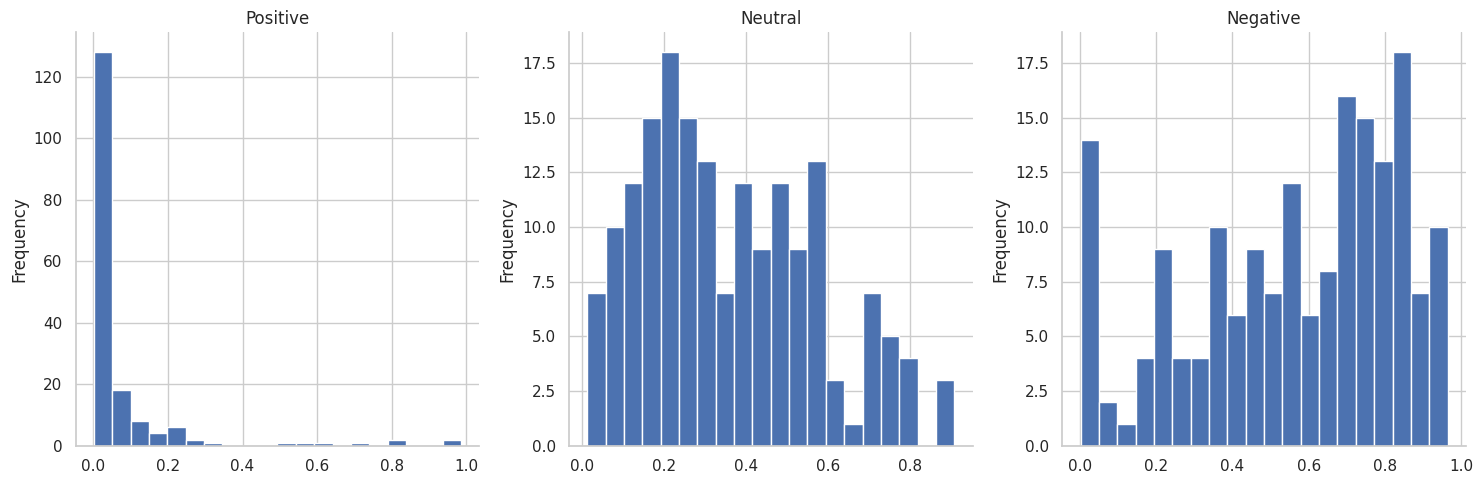

In [ ]:
# Distribuions

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df['positive'].plot(kind='hist', bins=20, ax=axes[0], title='Positive')
axes[0].spines[['top', 'right']].set_visible(False)

df['neutral'].plot(kind='hist', bins=20, ax=axes[1], title='Neutral')
axes[1].spines[['top', 'right']].set_visible(False)

df['negative'].plot(kind='hist', bins=20, ax=axes[2], title='Negative')
axes[2].spines[['top', 'right']].set_visible(False)

plt.tight_layout()

# Show the combined image
plt.show()

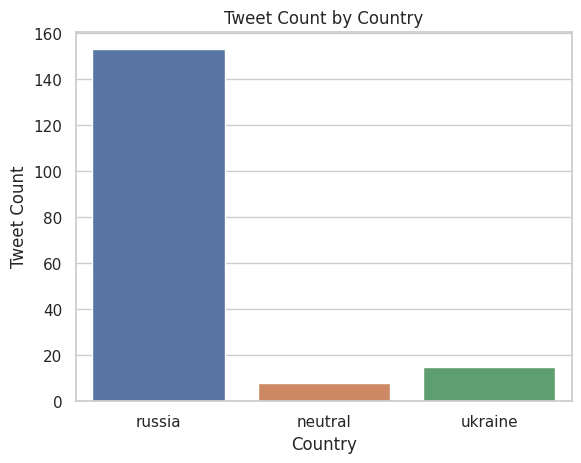

In [ ]:
# Create a bar plot for the count of tweets about each country
sns.countplot(x='tweet_about', data=df)
plt.title('Tweet Count by Country')
plt.xlabel('Country')  # Add x-axis label for better clarity
plt.ylabel('Tweet Count')  # Add y-axis label for better clarity
plt.show()

The analysis of tweet counts by country reveals a substantial disparity, with a notably higher volume of tweets pertaining to Russia compared to those centered around Ukraine. Moreover, a discernible trend is observed where a smaller proportion of tweets remains neutral, indicating a lower prevalence of content that does not exhibit bias towards either country. This discrepancy in tweet distribution underscores the varying levels of attention and engagement on the Twitter platform regarding discussions related to Russia and Ukraine, with a notable concentration on the former.

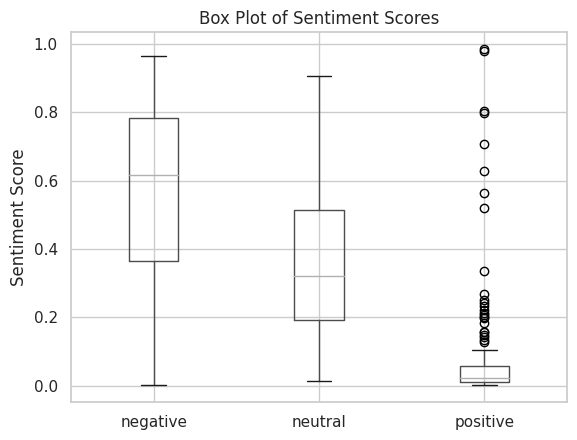

In [ ]:
sentiment_cols = ['negative', 'neutral', 'positive']

# Box plot of sentiment scores
df[sentiment_cols].boxplot()
plt.title('Box Plot of Sentiment Scores')
plt.ylabel('Sentiment Score')  # Add y-axis label for better clarity
plt.show()

The box plot of sentiment scores indicates a notable prevalence of tweets with high probabilities of being classified as negative. The presence of a substantial number of outliers in the positive sentiment range suggests that a minority of tweets exhibits a distinct positive sentiment, while the majority tends towards a negative sentiment. This observation underscores the prevalence of negative sentiment within the analyzed Twitter dataset, as reflected by the distribution of sentiment scores.

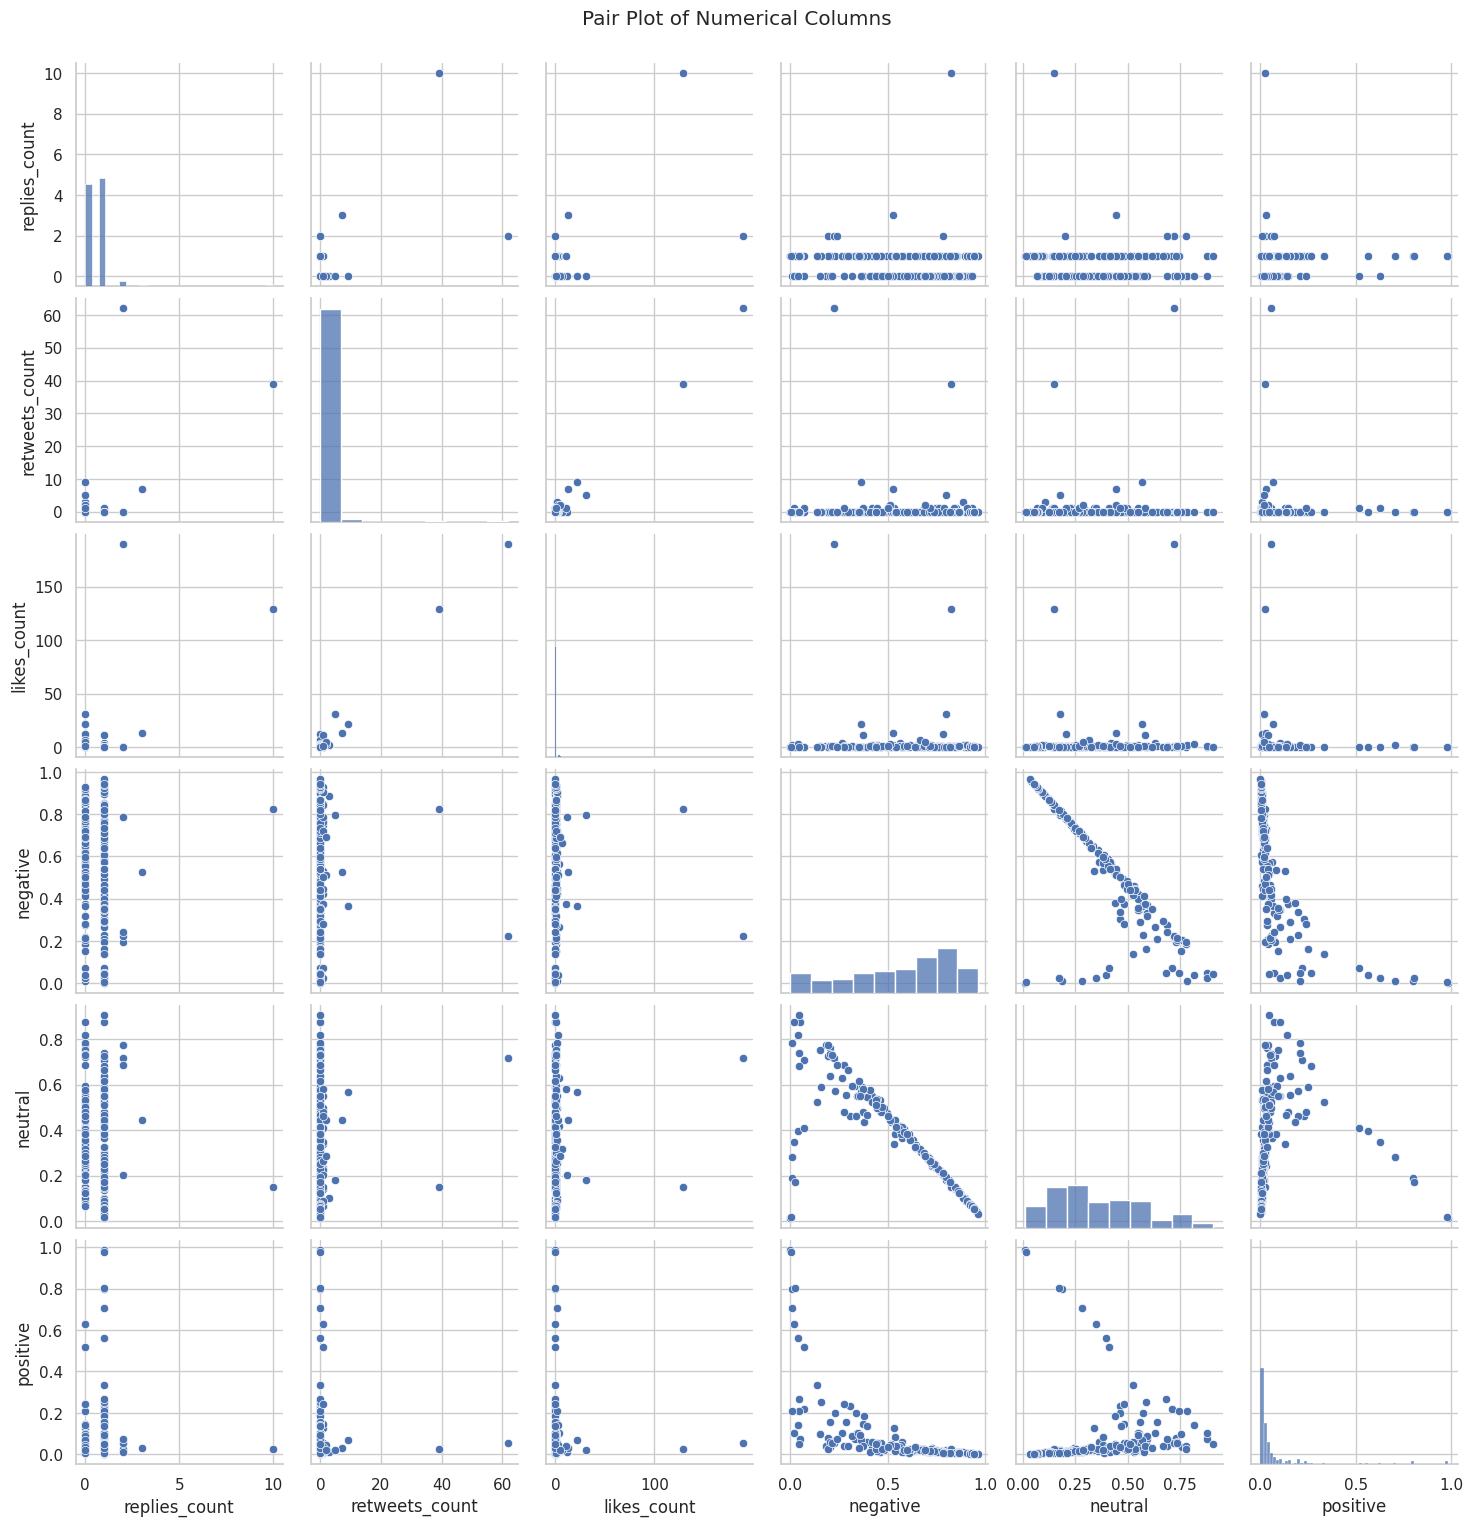

In [ ]:
# Pair plot for numerical columns
sns.pairplot(df[['replies_count', 'retweets_count', 'likes_count'] + sentiment_cols])
plt.suptitle('Pair Plot of Numerical Columns', y=1.02)
plt.show()

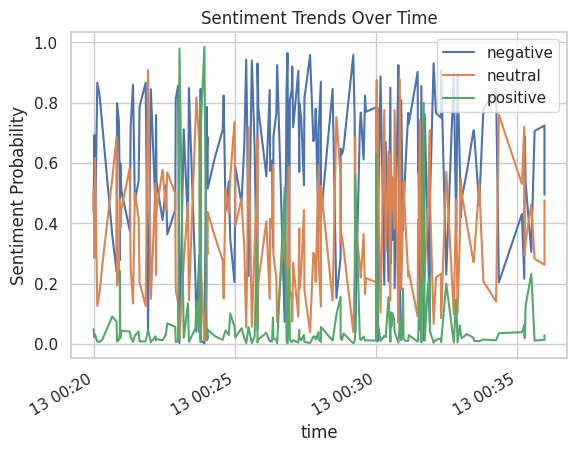

In [ ]:
# Line plot of sentiment probabilities over time (assuming you have a datetime column)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df[sentiment_cols].plot(style='-')
plt.title('Sentiment Trends Over Time')
plt.xlabel('time')  # Add x-axis label for better clarity
plt.ylabel('Sentiment Probability')  # Add y-axis label for better clarity
plt.show()

The generated line plot visually presents the temporal trends of sentiment probabilities over time for a set of tweets, as depicted in the DataFrame. Each line on the graph corresponds to a different sentiment category (positive, negative, neutral), with the x-axis representing time and the y-axis illustrating the respective sentiment probabilities. The datetime column in the DataFrame has been converted to a datetime format and set as the index for a more intuitive representation of time progression. The intricate intertwining of the lines suggests a dynamic and potentially complex sentiment landscape, where fluctuations in sentiment probabilities occur over distinct time intervals. The plot serves as a comprehensive visualization, allowing for the identification of patterns, peaks, and troughs in sentiment trends, providing valuable insights into the evolving emotional tone of the tweet dataset over the recorded time period. The title, x-axis label ('time'), and y-axis label ('Sentiment Probability') contribute to the clarity and interpretability of the graph, enabling a more informed understanding of how sentiments evolve over time in the dataset.

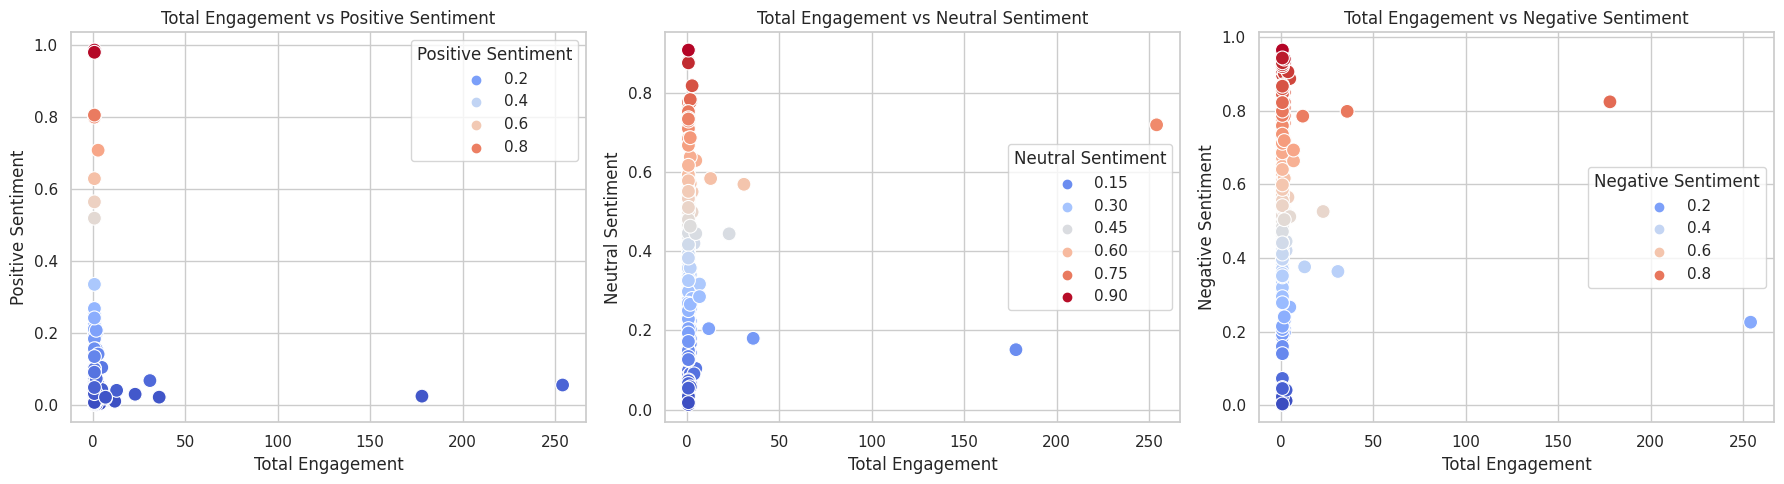

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Scatter plot between total engagement and positive sentiment
sns.scatterplot(x='total_engagement', y='positive', data=df, hue='positive', palette='coolwarm', edgecolor='w', s=100, ax=axes[0])
axes[0].set_title('Total Engagement vs Positive Sentiment')
axes[0].set_xlabel('Total Engagement')
axes[0].set_ylabel('Positive Sentiment')
axes[0].legend(title='Positive Sentiment')

# Scatter plot between total engagement and neutral sentiment
sns.scatterplot(x='total_engagement', y='neutral', data=df, hue='neutral', palette='coolwarm', edgecolor='w', s=100, ax=axes[1])
axes[1].set_title('Total Engagement vs Neutral Sentiment')
axes[1].set_xlabel('Total Engagement')
axes[1].set_ylabel('Neutral Sentiment')
axes[1].legend(title='Neutral Sentiment')

# Scatter plot between total engagement and negative sentiment
sns.scatterplot(x='total_engagement', y='negative', data=df, hue='negative', palette='coolwarm', edgecolor='w', s=100, ax=axes[2])
axes[2].set_title('Total Engagement vs Negative Sentiment')
axes[2].set_xlabel('Total Engagement')
axes[2].set_ylabel('Negative Sentiment')
axes[2].legend(title='Negative Sentiment')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined image
plt.show()

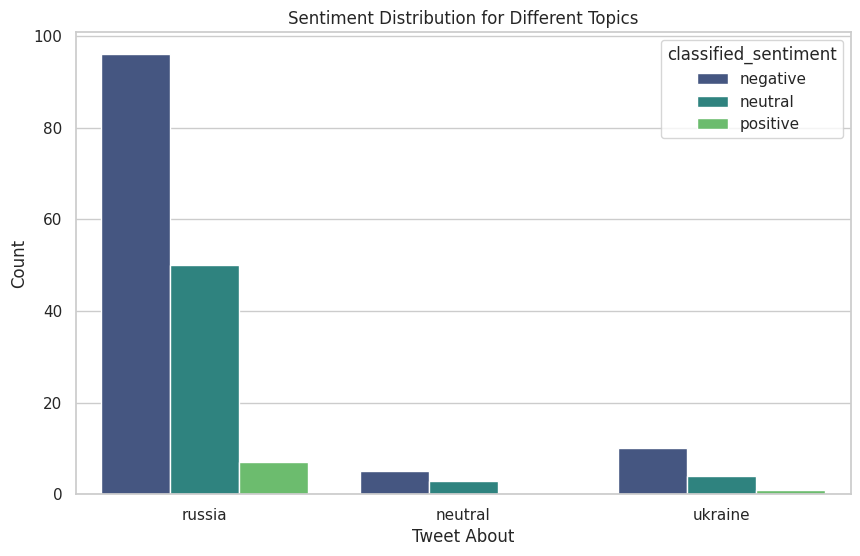

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='tweet_about', hue='classified_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution for Different Topics')
plt.xlabel('Tweet About')
plt.ylabel('Count')
plt.show()

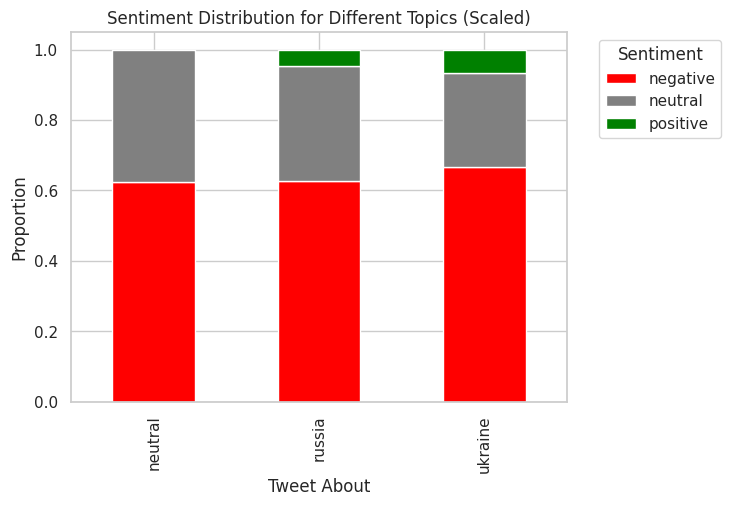

In [ ]:
df_grouped = df.groupby(['tweet_about', 'classified_sentiment']).size().unstack(fill_value=0)
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)

# Plot stacked bar plot
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
ax = df_grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in df_grouped.columns])

# Customize plot
plt.title('Sentiment Distribution for Different Topics (Scaled)')
plt.xlabel('Tweet About')
plt.ylabel('Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The analysis delves deeper into the sentiment trends observed in tweets, revealing an intriguing pattern that leans toward positivity, particularly in discussions related to Ukraine. This noteworthy inclination toward positive sentiment, however, is juxtaposed against a backdrop of a comparatively lower volume of tweets explicitly addressing Ukraine. This confluence of insights implies that despite the relatively limited volume of discourse on Ukraine, the sentiment expressed within this specific subset tends to be predominantly positive. The juxtaposition prompts further exploration into the nature of the positive sentiments expressed, raising questions about the factors influencing this positive sentiment trend in the context of discussions surrounding Ukraine. This nuanced understanding adds layers to the interpretation of sentiment dynamics in social media discourse, suggesting that the sentiment landscape can vary not only based on the content but also on the volume and intensity of discussions around specific topics like Ukraine.